In [10]:
#note: need pytorch for this
import json
import numpy as np
import torch
from torch import nn
import random
from torch import cuda
import math
from statistics import mean,stdev

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
#open data
#open up the stock json file
with open(r"C:\Users\Brian\Desktop\ML\project\data\all_data_dvsize20.json", "r") as f:
    data = json.loads(f.read())
#prepare data for usage with pytorch
#needs to be tensor of shape (batch_size, sequence_lenght, num_features)
#batch size could just be all of the samples 
#so X[0] = sample 0, X[0][0] = the features for sample 0 at time step 0
num_samples = len(data)

seq_length = len(data[0].get('stock_data')) #all the time steps, probably dont want this many
#Modify this and see how loss responds 
seq_length = 5

num_features = 4      #use open, high, low, close
num_news_features = 20  #may change

X = np.zeros((num_samples,seq_length,num_features))
X_news = np.zeros((num_samples, num_news_features))
y = np.zeros((num_samples,num_features)) #next day features, what we want to predict. [open high low close]
for i,d in enumerate(data):
    doc_feat = d.get("docvec")
    X_news[i] = doc_feat
    sd = d.get("stock_data")
    rec_feat = []
    k=0
    for j,day in enumerate(sd):
        #only grab the seq_length most recent days
        if j < (len(sd)-seq_length-1):
            continue
        #if its the last day, use as prediction
        if j == len(sd)-1:
            y[i] = [sd.get(day).get("open"), sd.get(day).get("high"), sd.get(day).get("low"), sd.get(day).get("close")]
            break
        
        #feature for 1 time stamp
        x = [sd.get(day).get("open"), sd.get(day).get("high"), sd.get(day).get("low"), sd.get(day).get("close")] 
            #sd.get(day).get("volume")]    
        X[i,k]=x
        k+=1

#do the train test split manually, so we can get the indices too
train_inds = [random.randint(0, len(X)-1) for iter in range(math.floor((len(X)-1) * 0.8))]
test_inds = np.setdiff1d(np.arange(0, len(X)-1), train_inds)

X_train = torch.from_numpy(X[train_inds]).type(torch.DoubleTensor)
X_news_train = torch.from_numpy(X_news[train_inds]).type(torch.DoubleTensor)
y_train = torch.from_numpy(y[train_inds]).type(torch.DoubleTensor)
X_test = torch.from_numpy(X[test_inds]).type(torch.DoubleTensor)
X_news_test = torch.from_numpy(X_news[test_inds]).type(torch.DoubleTensor)
y_test = torch.from_numpy(y[test_inds]).type(torch.DoubleTensor)        

X_news = torch.from_numpy(X_news).type(torch.DoubleTensor)
X = torch.from_numpy(X).type(torch.DoubleTensor)
y = torch.from_numpy(y).type(torch.DoubleTensor)

In [12]:
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [13]:
#following this tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

class news_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, doc_feat_size):
        super(news_RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
        
        hh = math.floor((hidden_size+doc_feat_size)/2)
        
        self.fc1 = nn.Linear(hidden_size + doc_feat_size, hh)  #reduce to half the hidden layers
        self.fc2 = nn.Linear(hh, output_size)  #do the regression (output_size=1)        
        
        self.relu = nn.ReLU()

    def forward(self, input, hidden, news_feat):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined).double()
        
        if len(news_feat)>0:
            concat = torch.cat((output[0], news_feat),0).float()
            fc_out = self.fc1(concat)
            fc_out = self.relu(fc_out)
            fc_out = self.fc2(fc_out)
            #fc_out = self.relu(fc_out)
            output = fc_out
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#Modify this and see how loss responds 
n_hidden = 20

model = news_RNN(num_features, n_hidden, 1, num_news_features).float()

# Define hyperparameters
n_epochs = 100
lr=0.00001

# Define Loss, Optimizer
criterion = nn.L1Loss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #best performance so far
#try different optimizers! : https://pytorch.org/docs/stable/optim.html

In [14]:
#training function
def train(x, y, news_feat):  #x would be a whole training sample, so all time steps:
    model.train()
    optimizer.zero_grad()
    hidden = model.initHidden().float()
    for j,ts in enumerate(x):
        ts = torch.tensor(np.reshape(ts,(1,ts.shape[0]))).float()
        if j == len(x)-1: #if its the last one, also pass in the news feature
            output, hidden = model(ts, hidden, news_feat)
        else:
            output, hidden = model(ts, hidden, [])
        
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
     # Add parameters' gradients to their values, multiplied by learning rate
    #for p in model.parameters():
    #    p.data.add_(-lr, p.grad.data)
    return output, loss.item()

#testing function
def test(x, news_feat):
    model.eval()
    
    hidden = model.initHidden().float()
    for j,ts in enumerate(x):
        ts = torch.tensor(np.reshape(ts,(1,ts.shape[0]))).float()
        if j == len(x)-1: #if its the last one, also pass in the news feature
            output, hidden = model(ts,hidden,news_feat)
        else:
            output, hidden = model(ts, hidden,[])
    y_pred = output
    return y_pred

#helper function for modifying the learning rate
def adjust_learning_rate(optimizer, epoch):
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            #print(param_group['lr'])
            param_group['lr'] = param_group['lr'] * 0.5

In [ ]:
# Run the training procedure
#device = torch.device("cpu")
#model.to(device)
#X.to(device)
#y.to(device)
losses=[]
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    l=0
    for i,x in enumerate(X_train):
        target = torch.tensor([y[i,0]])
        output, loss = train(x, target, X_news_train[i])
        l+=loss
    losses.append(l/len(X_train))
    adjust_learning_rate(optimizer, epoch)

%matplotlib notebook
plt.plot(np.arange(0,n_epochs), losses)
plt.title("Average Training loss")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")

In [ ]:
#run the testing procedure
losses=[]
for i,x in enumerate(X_test):
    target = torch.tensor([y_test[i,0]])
    output = test(x, X_news_test[i])
    loss = abs(target.item()-output.item())
    losses.append(loss)
    #print("Output: " + str(output.item()))
    #print("Actual: " + str(target.item()))
    #print("Loss: " + str(loss))
    #print()
print("Average loss: " + str(mean(losses)))
print(x)

In [ ]:
#do hold one out evaluation, train on all but 1 sample, test on the sample
from sklearn.model_selection import LeaveOneOut

train_losses = []
test_losses = []

#for epoch in range(1, n_epochs + 1):
loo = LeaveOneOut()
train_losses=[]
test_losses=[]
k=0
for train_split, test_split in loo.split(X): #use the whole set
    model = news_RNN(num_features, n_hidden, 1, num_news_features).float()
    #set the hold out example
    X_test = X[test_split,:]
    X_news_test = X_news[test_split,:]
    y_test = y[test_split]
    X_train = X[train_split,:]
    X_news_train = X_news[train_split,:]
    y_train = y[train_split]

    #do training
    l=0
    for i,x in enumerate(X_train):
        target = torch.tensor([y_train[i,0]])
        output, loss = train(x, target,X_news_train[i])
        l+=loss
    #train_loss+=l/len(X_train)
    train_losses.append(l/len(X_train))
    #do test
    output = test(X_test[0],X_news_test[0])
    loss = abs(y_test[0,0].item()-output.item())
    #test_loss+=loss
    test_losses.append(loss)
    
%matplotlib notebook
plt.plot(np.arange(0,len(X)-1), train_losses[0:-1], 'b')
plt.title("Average Training loss")
plt.xlabel("Split")
plt.ylabel("Average L1 Loss")

plt.plot(np.arange(0,len(X)-1), test_losses[0:-1], 'r')
plt.title("Test losses")
plt.xlabel("Split")
plt.ylabel("Average L1 Loss")

c:\users\brian\anaconda3\envs\pytorch_geometric\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
c:\users\brian\anaconda3\envs\pytorch_geometric\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<IPython.core.display.Javascript object>


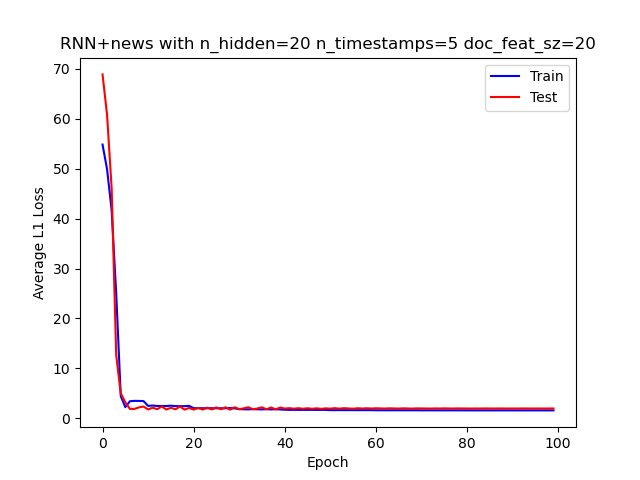

In [15]:
#run the training and testing procedures concurrently, showing progress of errors
#model = RNN(num_features, n_hidden, 1).float()

test_err_distribution = []
#repeat 10 times, average results
for z in range(10):
    train_inds = [random.randint(0, len(X)-1) for iter in range(math.floor((len(X)-1) * 0.8))]
    test_inds = np.setdiff1d(np.arange(0, len(X)-1), train_inds)

    X_train = torch.from_numpy(X.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    X_news_train = torch.from_numpy(X_news.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    y_train = torch.from_numpy(y.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    X_test = torch.from_numpy(X.detach().numpy()[test_inds]).type(torch.DoubleTensor)
    X_news_test = torch.from_numpy(X_news.detach().numpy()[test_inds]).type(torch.DoubleTensor)
    y_test = torch.from_numpy(y.detach().numpy()[test_inds]).type(torch.DoubleTensor)   
    
    model = news_RNN(num_features, n_hidden, 1, num_news_features).float()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses=[]
    test_losses = []
    for epoch in range(1, n_epochs + 1):
        #optimizer.zero_grad() # Clears existing gradients from previous epoch
        l=0
        for i,x in enumerate(X_train):
            target = torch.tensor([y_train[i,0]])
            output, loss = train(x, target,X_news_train[i])
            l+=loss
        train_losses.append(l/len(X_train))
        l=0
        for i,x in enumerate(X_test):
            target = torch.tensor([y_test[i,0]])
            output = test(x,X_news_test[i])
            loss = abs(target.item()-output.item())
            l+=loss
        test_losses.append(l/len(X_test))
        adjust_learning_rate(optimizer, epoch)
        
    test_err_distribution.append(test_losses[-1])
    if z==9:
        %matplotlib notebook
        plt.plot(np.arange(0,n_epochs), train_losses, 'b', label="Train")
        plt.plot(np.arange(0,n_epochs), test_losses, 'r', label="Test")
        plt.legend()
        plt.title("RNN+news with n_hidden={} n_timestamps={} doc_feat_sz={}".format(n_hidden, seq_length, num_news_features))
        plt.xlabel("Epoch")
        plt.ylabel("Average L1 Loss")
        plt.savefig("newsrnn_n{}_t{}_loss.png".format(n_hidden,seq_length), bbox_inches='tight')

In [16]:
print(mean(test_err_distribution))
print(stdev(test_err_distribution))

1.7263619469297056
0.5814893358167115
